In [1]:
from enum import Enum
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy

In [15]:
class Nodes:
    # set of general mathematical primitives from which superposition will be constructed
    # the second element of each pair is the number of arguments of function
    SIN = (lambda x : np.sin(x[0]), 1)
    COS = (lambda x : np.cos(x[0]), 1)
    SQRT = (lambda x : np.sqrt(x[0]), 1)
    POW = (lambda x : (x[0] + 1E-20) ** x[1], 2)
    SUM = (lambda x : x[0] + x[1], 2)
    SUB = (lambda x : x[0] - x[1], 2)
    PROD = (lambda x : x[0] * x[1], 2)
    FRAC = (lambda x : x[0] / (x[1] + 1E-20), 2)
    TAN = (lambda x : np.tan(x[0]), 1)
    ASIN = (lambda x : np.arcsin(x[0]), 1)
    ACOS = (lambda x : np.arccos(x[0]), 1)
    ATAN = (lambda x : np.arctan(x[0]), 1)
    EXP = (lambda x : np.exp(x[0]), 1)
    LOG = (lambda x : np.log(x[0]), 1)
    NEG = (lambda x : -x[0], 1)
    
    LIST = [SIN, COS, SQRT, SUM, SUB, PROD, FRAC, LOG, NEG]

# this class is implementation of tree node   
class Node:
    def __init__(self):
        self.fun = None
        self.args = []

    def __init__(self, fun, args):
        self.fun = fun
        self.args = args

    # generation of random superposition of given depth
    def __init__(self, wide):
        wide -= random.randint(0, 1)
        if wide <= 0:
        # creation of a leave
        # if self.args[0] == 1 then the node corresponds to tf value
        # else if self.args[0] == 1 then the node corresponds to idf value
        # else it corresponds to a constant with value self.args[1]
            self.fun = None
            self.args = []
            self.args.append(random.randint(0, 2))
            
            if self.args[0] == 2:
                self.args.append((random.random() - 0.5) * 10)
        else:
            new_node = Nodes.LIST[random.randint(0, len(Nodes.LIST) - 1)]
            self.fun = new_node[0]
            self.args = [Node(wide - 1) for _ in range(new_node[1])]

    # evaluation of the function value
    def calc(self, tf, idf):
        if self.fun is None:
            if self.args[0] == 0:
                return tf
            elif self.args[0] == 1:
                return idf
            else:
                return self.args[1]
        ans = self.fun([arg.calc(tf, idf) for arg in self.args])
        if type(ans) == complex:
            return 0.
        if ans != ans:
            return 0.
        if abs(ans) > 1e3:
            return ans / abs(ans) * 1e3
        
        return ans
    
    # the number of nodes in the tree
    def number(self):
        if self.fun is None:
            return 1
        return 1 + sum([node.number() for node in self.args])
    
    # get Nth node in the tree
    def getNth(self, n):
        i = 0
        while self.args[i].number() <= n:
            n -= self.args[i].number()
            i += 1
        if n == 0:
            return self, i
        return self.args[i].getNth(n - 1)

    # get random subtree
    def getRandom(self):
        rnd = random.randint(0, self.number() - 2)
        return self.getNth(rnd)

# the class for population
class Being:

    def __init__(self, wide):
        self.tree = Node(wide)
    
    def getRandom(self):
        return self.tree.getRandom()

    def reit(self, args, labels):
        err = np.array([self.calc(arg, 0.) for arg in args]) - np.array(labels)
        return np.sum(np.abs(err) ** 2)

    def calc(self, tf, idf):
        return self.tree.calc(tf, idf)
    
    def number(self):
        return self.tree.number()


In [12]:
X = np.array([random.random() * 4 for _ in range(30)])
Y = X ** 3 + np.sqrt(np.log(X + 1)) * 2

In [16]:
generation = [Being(4) for _ in range(100)]

In [17]:
generation = sorted(generation, key=lambda being : being.reit(X, Y))
print (generation[0].reit(X, Y))
print (generation[0].reit(X, Y))
print (generation[0].reit(X, Y))
print (generation[0].reit(X, Y))
print (generation[1].reit(X, Y))
print (generation[2].reit(X, Y))
print (generation[3].reit(X, Y))

6217.955363518014
6217.955363518014
6217.955363518014
6217.955363518014
6244.85496561133
7558.633809906089
7698.039413866547


/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


In [18]:
line = np.linspace(0, 4, 20)

/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


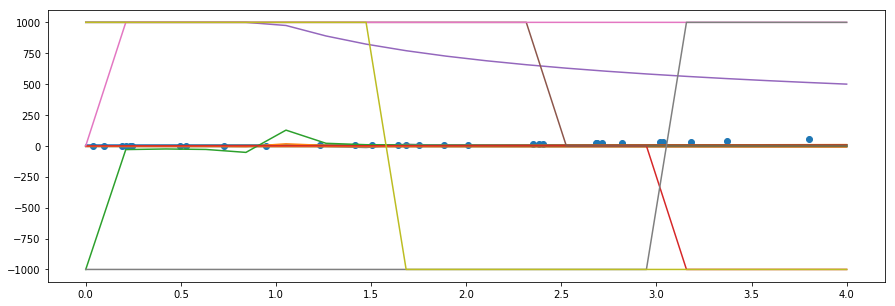

In [19]:
plt.figure(figsize=(15, 5))
plt.scatter(X, Y)
for being in generation:
    plt.plot(line, [being.calc(p, 0) for p in line])
plt.show()

In [20]:
def crossfit(x, y):
    x_ = deepcopy(x)
    y_ = deepcopy(y)
    n1, id1 = x_.getRandom()
    n2, id2 = y_.getRandom()
    n1.args[id1], n2.args[id2] = n2.args[id2], n1.args[id1]
    return x_

In [21]:
def mutation_rand_tree(x):
    x_ = deepcopy(x)
    n1, id1 = x_.getRandom()
    n1.args[id1] = Node(3)
    return x_

iteration number 0


/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


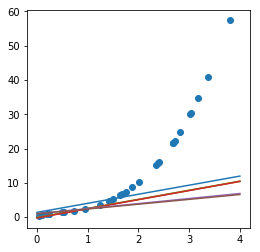

5527.740278611526
iteration number 10


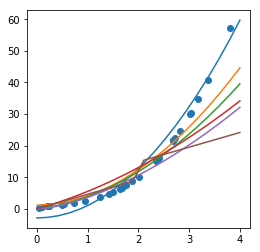

252.73720522223502
iteration number 20


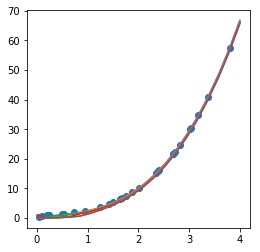

1.33111634590435
iteration number 30


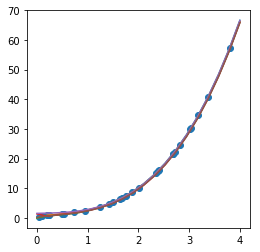

0.30549040672577094
iteration number 40


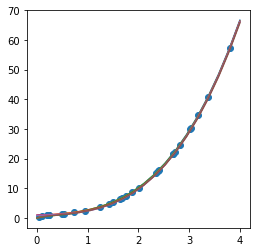

0.30549040672577094
iteration number 50


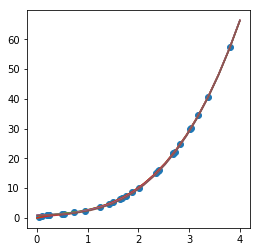

0.10957891417317854
iteration number 60


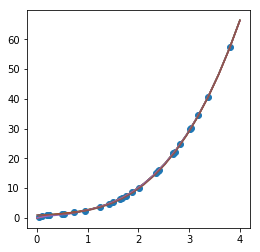

0.1286905360877568
iteration number 70


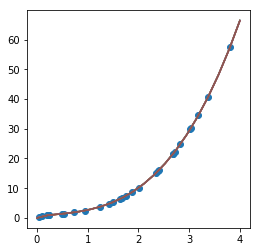

0.047518308024466015
iteration number 80


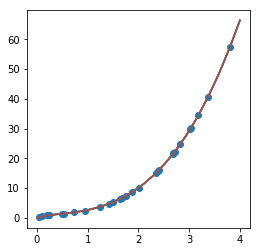

0.05774428190286475
iteration number 90


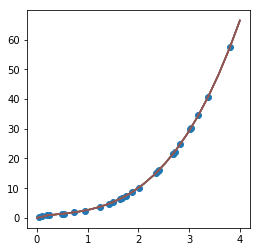

0.024674841218585566


In [22]:
reit_ = 1e9
last_reit = 1e9
SIMILARITY = 1e-5

for iteration in range(100):
    gen2 = []
    sz = len(generation)
    
    gen2.append(generation[0])
    
    for i in range(sz // 30):
        gen2.append(mutation_rand_tree(generation[0]))
        gen2.append(mutation_rand_tree(generation[1]))
        gen2.append(mutation_rand_tree(generation[2]))
    for i in range(sz // 10):
        gen2.append(Being(4))
    for i in range(sz):
        t1 = generation[random.randint(0, sz / 2)]
        t2 = generation[random.randint(0, sz / 2)]
        gen2.append(mutation_rand_tree(crossfit(t1, t2)))
        
    generation = sorted(generation + gen2, key=lambda being : being.reit(X, Y) + being.number() / 200.)
    vals = [np.array([being_.calc(p, 0) for p in line]) for being_ in generation[:20]]
    
    
    
    ids = []
    for i in range(20):
        for q in range(i + 1, 20):
            #print (i, q)
            if (vals[i] - vals[q]).sum() < SIMILARITY:
                ids.append(q)
    ids = np.unique(ids)
    generation = [generation[i] for i in range(100 + len(ids)) if i not in ids]
    
    if iteration % 10 == 0:
        print("iteration number", iteration)
        plt.figure(figsize=(4, 4))
        plt.scatter(X, Y)
        plt.plot(line, [generation[0].calc(p, 0) for p in line])
        plt.plot(line, [generation[1].calc(p, 0) for p in line])
        plt.plot(line, [generation[2].calc(p, 0) for p in line])
        plt.plot(line, [generation[3].calc(p, 0) for p in line])
        plt.plot(line, [generation[4].calc(p, 0) for p in line])
        plt.plot(line, [generation[5].calc(p, 0) for p in line])
        plt.show()
    
        print (generation[0].reit(X, Y))